## Synthetic Numerical Optimization

Task:

Given a **goal** number, the LLM must come up with an **input** number that will get to the goal number (through a series of hidden numerical transformations).

Usage guide:
1. NumericalProgramSampler initialization defines the random search space for the program (but it does NOT generate the program)
   - `program = NumericalProgramSampler(chain_length=3, logic_prob=0, max_gen_var=2)`
   - This only defines a class of problems
   - `param_num` defines how many inputs it takes in.
   - `program.goal_input`: this is the correct answer for LLM to guess (LLM can't see this)
   - `program.goal_output`: this is the target goal (LLM can see this)
   - `program.display_computation_graph()`: shows the computation graph (calling backprop under the hood)
3. Sample a problem from the problem space:
   - `output = program(inpt, seed=3232)`
   - We currently use `seed` to uniquely specify a program. The same seed means regardless of input, it will go through the same program.
   - Different seed means different programs


### Trace Example

In [1]:
from number_synthetic import NumericalProgramSampler
from opto.trace.nodes import node
from opto.trace.nodes import GRAPH
from opto.trace.propagators import FunctionPropagator

In [2]:
program = NumericalProgramSampler(chain_length=3, param_num=1, logic_prob=0, max_gen_var=2)

In [3]:
y = program(node(5, "node_x"), seed=1234)

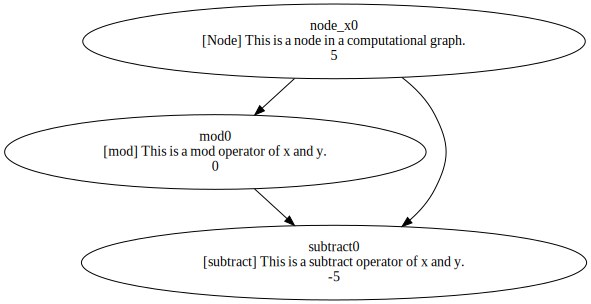

In [4]:
y.backward(visualize=True, feedback="Correct", propagate=FunctionPropagator())

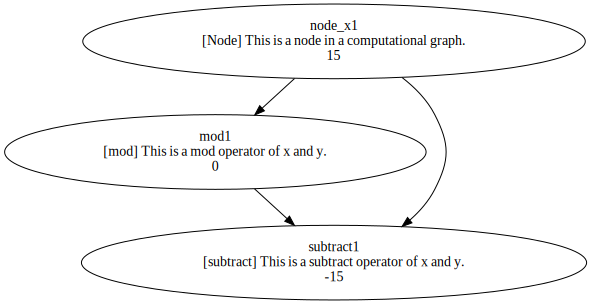

In [5]:
y = program(node(15, "node_x"), seed=1234)
y.backward(visualize=True, feedback="Correct", propagate=function_propagate())

### Torch Example

In [6]:
import torch

In [19]:
x = torch.tensor([5.0], requires_grad=True)
y = program(x, seed=1234)
y

tensor([-5.], grad_fn=<SubBackward0>)

In [20]:
y.backward()

In [21]:
x.grad

tensor([-1.])

## Optimization Loop Example

In [2]:
from number_synthetic import NumericalProgramSampler

import autogen
from opto.trace import bundle, node
from opto.optimizers import FunctionOptimizer
from opto.trace.nodes import GRAPH

In [3]:
GRAPH.clear()

program = NumericalProgramSampler(chain_length=3, param_num=1, logic_prob=0, max_gen_var=2, seed=1234)
print("Ground truth goal input", program.goal_input)
print("Target output:", program.goal_output)

x = node(-1.0, "input_x", trainable=True)

optimizer = FunctionOptimizer([x], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

history = [x.data]
feedback = ""
for i in range(10):
    print(f"optimization {i}")
    if feedback.lower() == "Success.".lower():
        break
    output = program(x, seed=1234)
    feedback = program.feedback(output.data)

    optimizer.zero_feedback()
    optimizer.backward(output, feedback)
    print(f"variable={x.data}, output={output.data}, feedback={feedback}")  # logging
    optimizer.step()

    history.append(x.data)  # logging

print("History")
for i, v in enumerate(history):
    print(f"  {i}: {v}")

Ground truth goal input [8]
Target output: 1
optimization 0
variable=-1.0, output=-0.0, feedback=The number needs to be larger.
optimization 1
variable=1.0, output=0.0, feedback=The number needs to be larger.
optimization 2
variable=0.6, output=0.40000000000000013, feedback=The number needs to be larger.
optimization 3
variable=1.6, output=1.0, feedback=Success.
optimization 4
History
  0: -1.0
  1: 1.0
  2: 0.6
  3: 1.6
  4: 1.6


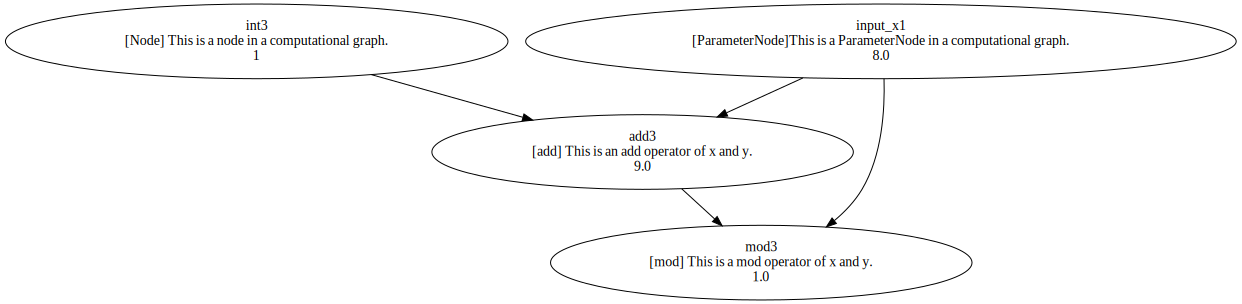

In [7]:
y.backward(visualize=True)